In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score, roc_curve
import matplotlib.pyplot as plt

### Reading Dataset

In [25]:
df = pd.read_csv('Fraud.csv')

In [26]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


## Data Cleaning

### Missing Values

In [27]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

We really don't seem to have any misisng values in this case.

### Detecting Outliers

In [28]:
df_sample = df.sample(frac =0.1, random_state =42)

C:\Users\lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


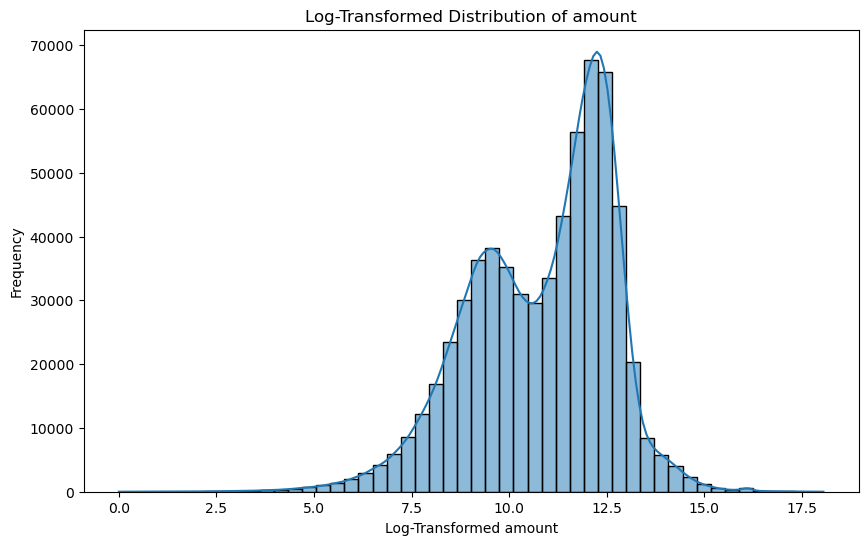

C:\Users\lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


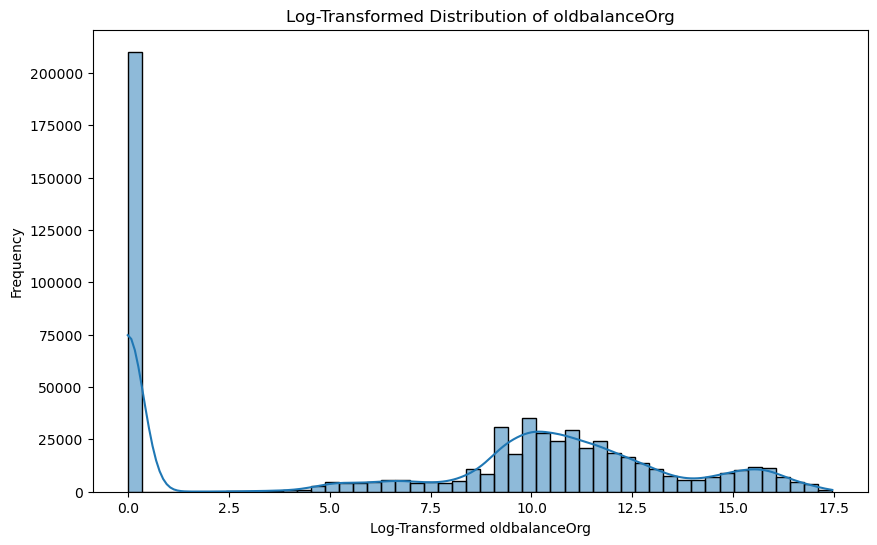

C:\Users\lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


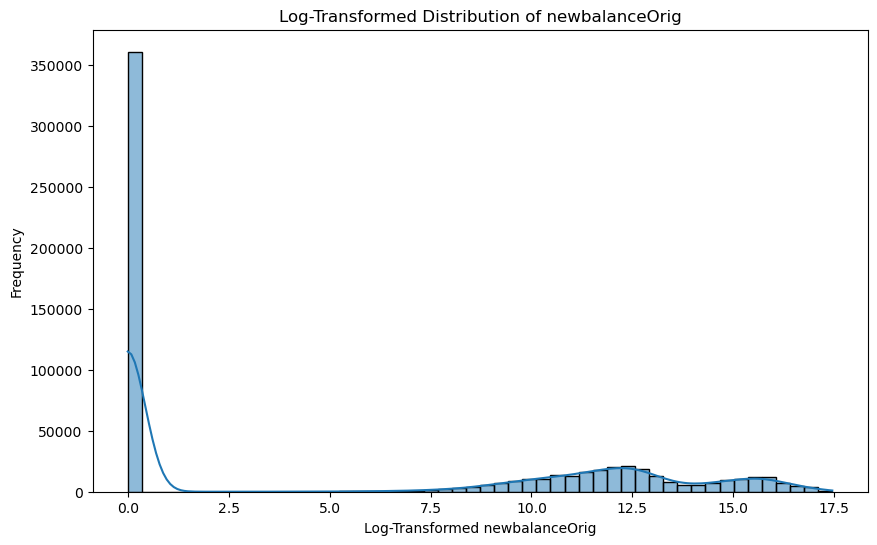

C:\Users\lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


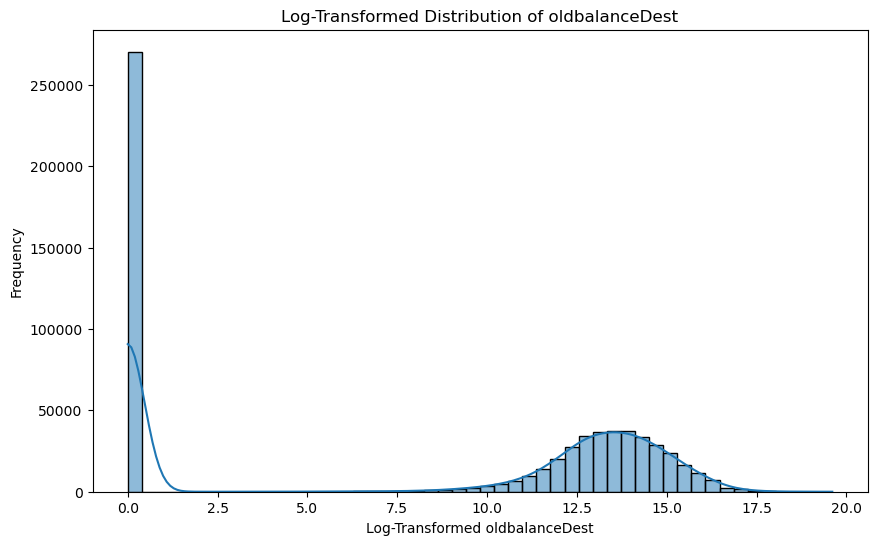

C:\Users\lenovo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


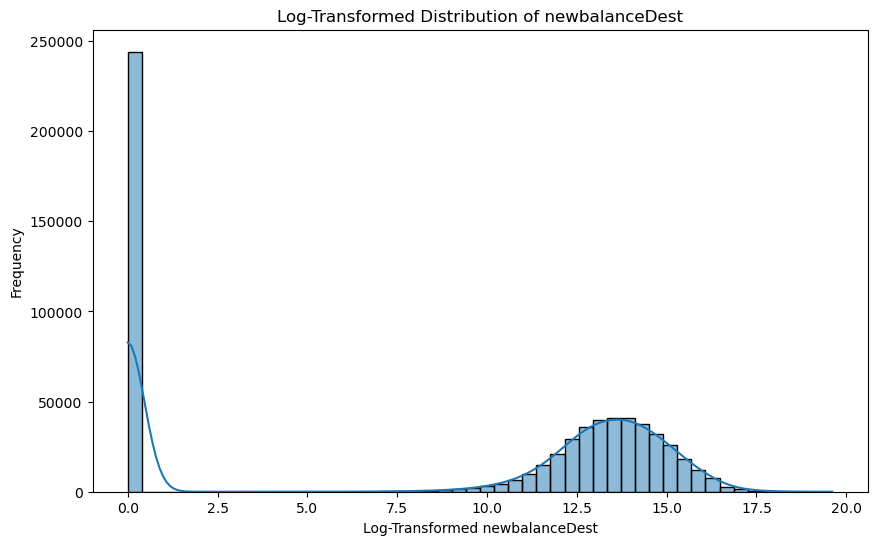

In [29]:
# Apply log transformation to columns
log_transformed_df = df_sample.copy()
columns_to_plot = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

for column in columns_to_plot:
    log_transformed_df[column] = np.log1p(log_transformed_df[column])  # log1p is log(1 + x) to handle zero values

# Plot distribution plots for log-transformed data
for column in columns_to_plot:
    plt.figure(figsize=(10, 6))
    sns.histplot(log_transformed_df[column], bins=50, kde=True)
    plt.title(f'Log-Transformed Distribution of {column}')
    plt.xlabel(f'Log-Transformed {column}')
    plt.ylabel('Frequency')
    plt.show()


#### We can see our data is highly skewed, thus we will use IQR method to handle these outliers in this case.

In [30]:
# Define a function to remove outliers based on IQR
def remove_outliers_iqr(df_sample, columns_to_plot):
    df_no_outliers = df_sample.copy()
    for column in columns_to_plot:
        Q1 = df_sample[column].quantile(0.25)
        Q3 = df_sample[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]
    return df_no_outliers

# Apply the function
df_final = remove_outliers_iqr(df_sample, columns_to_plot)

# Verify the change
print(f"Original shape: {df.shape}, after removing outliers: {df_final.shape}")


Original shape: (6362620, 11), after removing outliers: (439154, 11)


### Correlation

In [31]:
num_features = [feature for feature in df_sample.columns if df_sample[feature].dtype != 'O']
numerical_df = df_sample[num_features].drop(['step','isFraud','isFlaggedFraud'],axis =1)

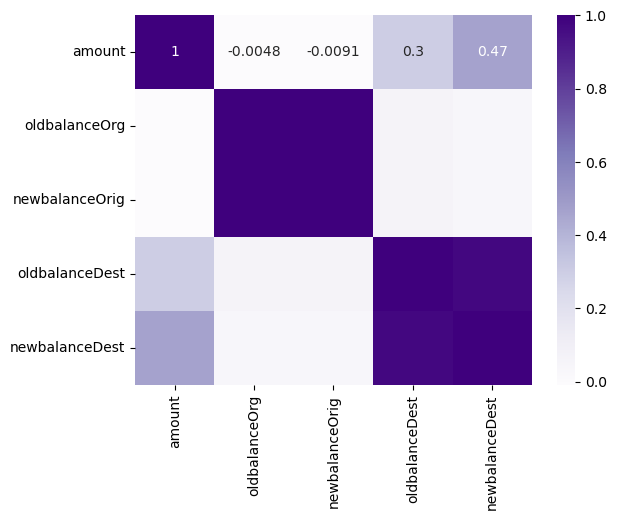

In [32]:
corr_matrix = numerical_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='Purples')
plt.show()

The correlation matrix is used to identify the strength and direction of linear relationships between pairs of variables. It helps detect multicollinearity, which occurs when two or more variables are highly correlated.

## Feature Engineering

In [33]:
# Apply log transformation
df_final[columns_to_plot] = df_final[columns_to_plot].apply(np.log1p)

# Encode categorical variables using one-hot encoding
df_encoded = pd.get_dummies(df_final, columns=['type'], drop_first=True)


## Feature Selection

In [34]:
# Select features and target variable
X = df_encoded.drop(['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)
y = df_encoded['isFraud']

In [35]:
## data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Selection

We will check for Logistisc Regression, Random Forest, Gradient Bossitng and SVM as well and then we will take help of ROC score 
as a performance metric to decide which algorithm to go forward with.As,it sums up how well a model can produce relative scores to discriminate between positive or negative instances across all classification thresholds. The ROC AUC score ranges from 0 to 1, where 0.5 indicates random guessing, and 1 indicates perfect performance.

In [37]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}

In [38]:
# Train and evaluate models
roc_auc_scores = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    roc_auc_scores[name] = roc_auc
    print(f'{name} ROC AUC Score: {roc_auc:.4f}')


Logistic Regression ROC AUC Score: 0.9856
Random Forest ROC AUC Score: 0.9306
Gradient Boosting ROC AUC Score: 0.9716
Support Vector Machine ROC AUC Score: 0.9909


To prevent overfitting with Random Forest, I'll tweak settings, focus on important features, and keep an eye on how well the model performs. This helps ensure the model doesn't get too caught up in the training data and can handle new data better.

## Random Forest

In [39]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [40]:
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    131651
           1       0.96      0.56      0.71        96

    accuracy                           1.00    131747
   macro avg       0.98      0.78      0.86    131747
weighted avg       1.00      1.00      1.00    131747



In [41]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[131649      2]
 [    42     54]]


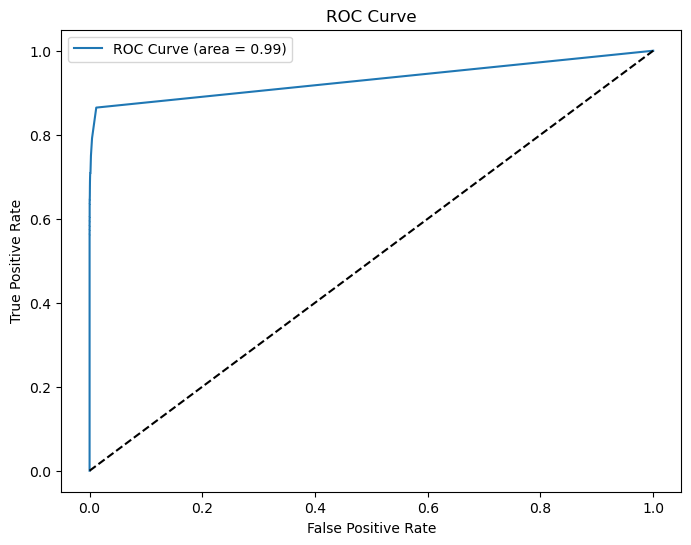

In [42]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [43]:
# Extract feature importances
importances = model.feature_importances_
feature_names = X.columns

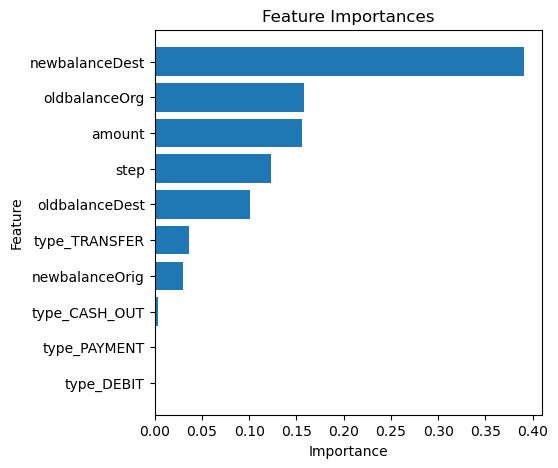

In [44]:
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(5, 5))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [99]:
new_data = pd.DataFrame({
    'step': [1],
    'type': ['PAYMENT'],
    'amount': [1000],
    'nameOrig': ['C123456789'],
    'oldbalanceOrg': [5000],
    'newbalanceOrig': [4000],
    'nameDest': ['M123456789'],
    'oldbalanceDest': [1000],
    'newbalanceDest': [2000],
    'isFlaggedFraud': [0]
})

In [100]:
# Assuming new_data is a DataFrame with new transactions
# Apply log transformation
new_data[columns_to_plot] = new_data[columns_to_plot].apply(np.log1p)

# Encode the 'type' column using one-hot encoding
new_data_encoded = pd.get_dummies(new_data, columns=['type'], drop_first=True)

# Ensure the new data has the same columns as the training data
new_data_encoded = new_data_encoded.reindex(columns=X_train.columns, fill_value=0)

# Standardize the new data
new_data_scaled = scaler.transform(new_data_encoded)

# Make predictions
new_predictions = model.predict(new_data_scaled)

In [101]:
new_prediction = model.predict(new_data_scaled)[0]
new_prediction_proba = model.predict_proba(new_data_scaled)[0]

# Output results
fraud_status = "Fraudulent" if new_prediction == 1 else "Not Fraudulent"
fraud_probability = new_prediction_proba[1]

print(f"Prediction: {fraud_status}")
print(f"Probability of Fraud: {fraud_probability:.2%}")

Prediction: Not Fraudulent
Probability of Fraud: 1.00%
